[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab10_diffusion.ipynb)

# Denoising Diffusion Probabilistic Models (DDPM)

## Description

In this lab, we train an image generation model using diffusion. Diffusion is just one of several techniques to generate images, but it has recently surpassed the GAN as the state-of-the-art generation model.

The diffusion model is trained to remove noise from images, and once it is fully trained it can take random noise and fully "denoise" it into an image that looks reasonably like the training set.

## Objectives
- Implement forward process of diffusion
- Implement backward process of diffusion
- Generate images with the diffusion process
- Answer questions about diffusion

## Grading Criteria
- Scheduling (10%)
- Forward Diffusion (30%)
- Backward Diffusion (30%)
- Image Generation (20%)
- Answers to Questions (10%)

### Helpful Reading
- Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2006.11239
- Improved Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2102.09672



In [1]:
from abc import abstractmethod
import math
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Compose, Resize, Lambda, ToTensor

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
# Hyperparameters
MAX_TIMESTEPS = 1000
image_size = 32
lr = .0001

We have given you a simpler version of the UNet used in "Improved Denoising Diffusion Probabilistic Models." Feel free to familiarize yourself with the model. It is similar to the UNet we made in the cancer detection lab, but has layers that incorporate the timestep embedding. The model is already fully implemented.

In [3]:
def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module


def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


# Note: this is an abstract method, do not implement `forward`
class TimestepBlock(nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.op = nn.Conv2d(channels, channels, 3, stride=2, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels

        self.in_layers = nn.Sequential(
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, self.out_channels, 3, padding=1)
        )
        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_channels, self.out_channels)
        )
        self.out_layers = nn.Sequential(
            nn.GroupNorm(32, self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(nn.Conv2d(self.out_channels, self.out_channels, 3, padding=1)),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Conv2d(channels, self.out_channels, kernel_size=1)

    def forward(self, x, emb):
        h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        h = h + emb_out
        h = self.out_layers(h)
        return self.skip_connection(x) + h


class UNetModel(nn.Module):
    """
    The full UNet model with timestep embedding.

    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    """

    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        num_res_blocks,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
    ):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = hidden_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.dropout = dropout
        self.channel_mult = channel_mult

        time_embed_dim = hidden_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(hidden_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.input_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, hidden_channels, 3, padding=1))
        ])
        input_block_chans = [hidden_channels]
        ch = hidden_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResBlock(ch, time_embed_dim, dropout, out_channels=mult * hidden_channels)]
                ch = mult * hidden_channels
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                self.input_blocks.append(TimestepEmbedSequential(Downsample(ch)))
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(ch, time_embed_dim, dropout),
            ResBlock(ch, time_embed_dim, dropout),
        )

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResBlock(
                        ch + input_block_chans.pop(),
                        time_embed_dim,
                        dropout,
                        out_channels=hidden_channels * mult,
                    )
                ]
                ch = hidden_channels * mult
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch))
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            nn.GroupNorm(32, ch),
            nn.SiLU(),
            zero_module(nn.Conv2d(hidden_channels, out_channels, 3, padding=1))
        )

    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.

        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x H x W] Tensor of outputs.
        """

        xs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        for module in self.input_blocks:
            x = module(x, emb)
            xs.append(x)
        x = self.middle_block(x, emb)
        for module in self.output_blocks:
            cat_in = torch.cat([x, xs.pop()], dim=1)
            x = module(cat_in, emb)
        return self.out(x)

# Part 1: Implement a linear and cosine scheduler

A scheduler is an important aspect to training a diffusion model. The scheduler returns a sequence of $\beta$ values, i.e. $[\beta_1, \cdots, \beta_T]$, that help determine how much noise is added to an image for training (forward process) and is removed from an image for inference (backward process). While the linear and cosine beta schedulers are valid ways of computing $\beta$s, the cosine scheduler is a better choice. Both schedulers should return 1-D tensors containing $[\beta_1, \cdots, \beta_T]$.

While we will only use t=1...T in training, we will need $\bar{\alpha}_0=1$ in the sampling function. To ensure $\bar{\alpha}_0 = 1$, you should prepend your list of $\beta$ with $\beta_0 = 0$. This will also ensure your indices match up with PyTorch's 0-indexed tensors.

**Tip:** Implement and use the linear beta scheduler first while you debug your diffusion model. Once you know your model works, then you can switch to the cosine scheduler for better results.

In [4]:
def linear_beta_schedule(timesteps):
    """
    Compute [β1,...,βT] linearly. Discussed in "Denoising Diffusion Probabilistic Models"
    Example values for β1, βT shown in 1st bullet point of Appendix B.
    """
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(beta_start, beta_end, timesteps)
    betas = torch.cat([torch.tensor([0.0]), betas])  # Prepend β0=0
    return betas

def cosine_beta_schedule(timesteps):
    """
    Compute [β1,...,βT] using eq. 17 of "Improved Denoising Diffusion Probabilistic Models"
    """
    s = 0.008
    steps = timesteps + 1  # Include t=0
    t = torch.linspace(0, timesteps, steps) / timesteps  # t from 0 to 1 inclusive
    f_t = torch.cos(((t + s) / (1 + s)) * (math.pi / 2)) ** 2
    alphas_cumprod = f_t / f_t[0]  # Normalize so that ᾱ0=1
    betas = torch.zeros(steps)
    alphas_cumprod_prev = alphas_cumprod[:-1]
    alphas_cumprod_next = alphas_cumprod[1:]
    betas[1:] = torch.clamp(1 - alphas_cumprod_next / alphas_cumprod_prev, max=0.999)
    return betas

It would be helpful to compute global variables for $\beta$, $\alpha$, and $\bar{\alpha}$ down below so you don't need to recompute them for the forward and backward process. $\alpha$ and $\bar{\alpha}$ are defined right above equation 4 in "Denoising Diffusion Probability Models."

Note that the cosine schedule uses $\bar{\alpha}$ to compute $\beta$. But since we clip $\beta$ after deriving it, you should recompute $\bar{\alpha}$ from $\alpha$ and the clipped $\beta$.

In [5]:
def compute_alpha(beta):
    alpha = 1 - beta
    return alpha

def compute_alpha_bar(alpha):
    alpha_bar = torch.cumprod(alpha, dim=0)
    return alpha_bar

Compute values for both schedulers.

In [6]:
# Choose the number of timesteps
MAX_TIMESTEPS = 1000

# Compute beta, alpha, and alpha_bar for the linear scheduler
beta_linear = linear_beta_schedule(MAX_TIMESTEPS)
alpha_linear = compute_alpha(beta_linear)
alpha_bar_linear = compute_alpha_bar(alpha_linear)

# Compute beta, alpha, and alpha_bar for the cosine scheduler
beta_cosine = cosine_beta_schedule(MAX_TIMESTEPS)
alpha_cosine = compute_alpha(beta_cosine)
alpha_bar_cosine = compute_alpha_bar(alpha_cosine)

Figure 5 of "Improved Denoising Diffusion Probabilistic Models" graphs the $\bar{\alpha}$ schedule. Graph both your $\bar{\alpha}$ schedulers to verify your schedulers are correct.

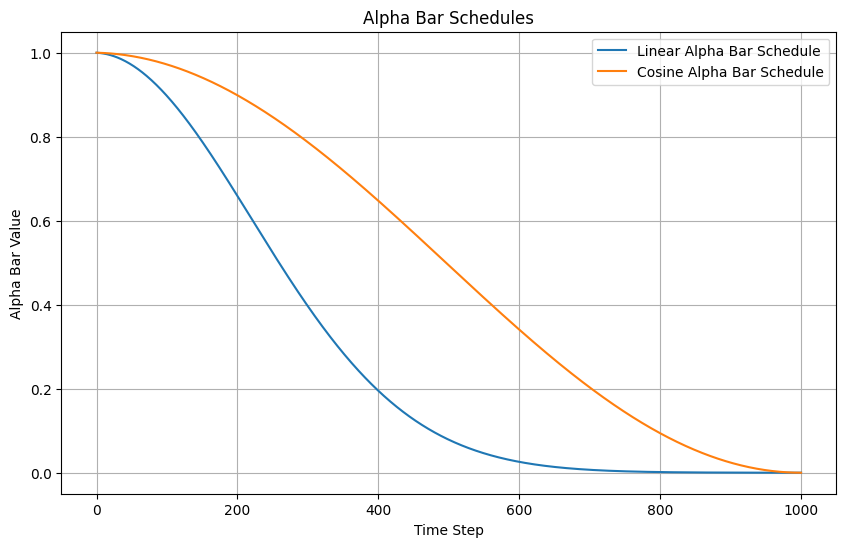

In [7]:
# Ensure alpha_bar tensors are on CPU
alpha_bar_linear_cpu = alpha_bar_linear.cpu()
alpha_bar_cosine_cpu = alpha_bar_cosine.cpu()

# Create a time steps array
timesteps = torch.arange(len(alpha_bar_linear_cpu))

# Plot alpha_bar for both schedulers
plt.figure(figsize=(10, 6))
plt.plot(timesteps, alpha_bar_linear_cpu, label='Linear Alpha Bar Schedule')
plt.plot(timesteps, alpha_bar_cosine_cpu, label='Cosine Alpha Bar Schedule')
plt.title('Alpha Bar Schedules')
plt.xlabel('Time Step')
plt.ylabel('Alpha Bar Value')
plt.legend()
plt.grid(True)
plt.show()

Select which scheduler to use. To prevent broadcasting images, reshape all three lists to (T, 1, 1, 1). Put the tensors on the device, and if you used NumPy to create the tensors, convert from double to floats.

In [8]:
# Select the scheduler to use
# Uncomment the scheduler you want to use

# For linear scheduler:
beta = beta_linear
alpha = alpha_linear
alpha_bar = alpha_bar_linear

# For cosine scheduler:
# beta = beta_cosine
# alpha = alpha_cosine
# alpha_bar = alpha_bar_cosine

# Reshape tensors to (T+1, 1, 1, 1)
beta = beta.view(-1, 1, 1, 1)
alpha = alpha.view(-1, 1, 1, 1)
alpha_bar = alpha_bar.view(-1, 1, 1, 1)

# Ensure tensors are float32
beta = beta.float()
alpha = alpha.float()
alpha_bar = alpha_bar.float()

# Move tensors to the device
beta = beta.to(device)
alpha = alpha.to(device)
alpha_bar = alpha_bar.to(device)

# Part 2: Implement the forward diffusion (training) process

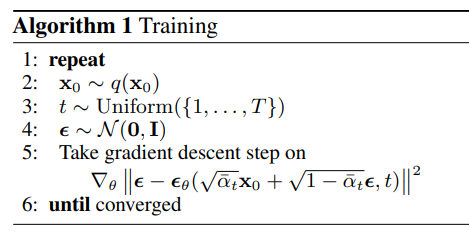

While you might be accustomed to pseudocode, deep learning pseudocode can sometimes be difficult to parse in the beginning and so we will explain all the steps here. The first thing to note is that **there is an implicit batch dimension included in the pseudocode**, so do not interpret this training loop as operating on a single image.

Line 2: Sample a batch of images $x_0$ from you dataset of images $q$. The subscript $0$ denotes the current timestep $t$, i.e. $x_{t=0} \equiv x_0$.

Line 3: Sample from the uniform distribution a batch of timesteps between 1 and $T$. The timesteps in the batch do not need to match.

Line 4: Sample noise from the normal distribution. In line 5 we see that the noise is going to be subtracted and multiplied element-wise to our batch of images. This means that the shape of the noise needs to match the shape of the batch of images, i.e. noise.shape = images.shape = (B, C, H, W).

Line 5: There is an implicit $x_t$ being created here where $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$. Therefore, $x_t$ and $t$ are passed into our diffusion model $\epsilon_{\theta}$. The model's goal is to predict the noise $\epsilon$ that was added into the model. $\lVert \epsilon - \epsilon_{\theta}(x_t, t) \rVert^2$ is our loss and it means to take the mean squared error between $\epsilon$ and our model's prediction of $\epsilon$. The final two parts of line 5 are $\nabla_{\theta}$ and "take the gradient descent step" which translates into pytorch as call `loss.backward()` and `optimizer.step()` respectively.

Lines 1 and 6 mean to continually train your model until there is no improvement.

In [9]:
def training(model, optimizer, dataloader, n_minibatches=1500):
    model.train()  # Set the model to training mode
    losses = []    # List to store the training losses
    batch_size = dataloader.batch_size
    T = MAX_TIMESTEPS  # Total number of timesteps

    # Ensure alpha_bar is properly shaped and on the correct device
    global alpha_bar

    # Initialize an iterator over the dataloader
    data_iter = iter(dataloader)
    minibatch_count = 0

    while minibatch_count < n_minibatches:
        try:
            # Get the next batch of data
            x0, _ = next(data_iter)
        except StopIteration:
            # Restart the iterator if we've reached the end of the dataset
            data_iter = iter(dataloader)
            x0, _ = next(data_iter)

        # Move images to the correct device and normalize to [-1, 1]
        x0 = x0.to(device) * 2 - 1

        # Sample a batch of timesteps t
        t = torch.randint(1, T+1, (x0.size(0),), device=device).long()

        # Sample noise epsilon
        epsilon = torch.randn_like(x0)

        # Get alpha_bar_t for each timestep in the batch
        alpha_bar_t = alpha_bar[t].to(device)  # Shape: [batch_size, 1, 1, 1]

        # Compute the noisy images x_t
        sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
        x_t = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * epsilon

        # Predict the noise using the model
        epsilon_theta = model(x_t, t)

        # Compute the loss (MSE between true noise and predicted noise)
        loss = F.mse_loss(epsilon_theta, epsilon)

        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss
        losses.append(loss.item())

        minibatch_count += 1

        # Print loss every so often
        if minibatch_count % 100 == 0:
            print(f"Minibatch {minibatch_count}/{n_minibatches}, Loss: {loss.item():.6f}")

    return losses

# Part 3: Implement the backward diffusion (sampling) process

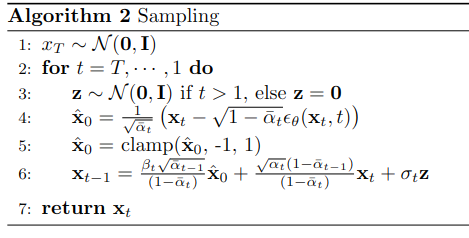

where $\bar{\alpha}_0 = 1$ and $\sigma_t = \sqrt{\beta_t}$.

**Note:** the only time $\alpha_t$ (without bar) is used instead of $\bar{\alpha}_t$ (with bar) is under the square root in the second term on line 6 (the numerator multiplied by $x_t$). If you mix up $\alpha$ and $\bar{\alpha}$, your sampling will not work!

In [10]:
@torch.no_grad()
def sampling(model, batch_size):
    model.eval()  # Set the model to evaluation mode

    # Parameters
    T = MAX_TIMESTEPS    # Total number of timesteps
    channels = 1         # Change to 1 for MNIST
    img_size = image_size  # Image size used during training

    # Initialize x_T from a normal distribution
    x_t = torch.randn(batch_size, channels, img_size, img_size).to(device)

    # Sampling loop from T to 1
    for t in range(T, 0, -1):
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)

        # Predict noise using the model
        epsilon_theta = model(x_t, t_batch)

        # Get alpha_t and alpha_bar_t
        alpha_t = alpha[t]         # Shape: [1, 1, 1, 1]
        alpha_bar_t = alpha_bar[t] # Shape: [1, 1, 1, 1]

        # Compute coefficients
        sqrt_recip_alpha_t = 1.0 / torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)

        # Compute model mean
        model_mean = sqrt_recip_alpha_t * (
            x_t - ((1 - alpha_t) / sqrt_one_minus_alpha_bar_t) * epsilon_theta
        )

        # Compute sigma_t and sample z
        beta_t = beta[t]
        if t > 1:
            sigma_t = torch.sqrt(beta_t)
            z = torch.randn_like(x_t)
        else:
            sigma_t = 0
            z = 0

        # Update x_t
        x_t = model_mean + sigma_t * z

    # Rescale x_t to [0, 1] and clamp values
    x_0 = (x_t + 1) / 2
    x_0 = x_0.clamp(0, 1)

    return x_0  # Return the generated images

# Part 4: Train and generate images

In [11]:
preprocess_transform = Compose([
    Resize(image_size),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1),
])

In [12]:
model = UNetModel(
        in_channels=1,
        hidden_channels=32,
        out_channels=1,
        num_res_blocks=2,
        dropout=0.,
        channel_mult=(1, 2, 2, 2),
    ).to(device)

batch_size = 24
dataset = torchvision.datasets.MNIST("data/", train=True, download=True, transform=preprocess_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = AdamW(model.parameters(), lr=lr)

In [13]:
train_losses = training(model, optimizer, dataloader)

Minibatch 100/1500, Loss: 0.315515
Minibatch 200/1500, Loss: 0.074068
Minibatch 300/1500, Loss: 0.062184
Minibatch 400/1500, Loss: 0.056888
Minibatch 500/1500, Loss: 0.059782
Minibatch 600/1500, Loss: 0.057668
Minibatch 700/1500, Loss: 0.024703
Minibatch 800/1500, Loss: 0.025508
Minibatch 900/1500, Loss: 0.044945
Minibatch 1000/1500, Loss: 0.059276
Minibatch 1100/1500, Loss: 0.042552
Minibatch 1200/1500, Loss: 0.044845
Minibatch 1300/1500, Loss: 0.024605
Minibatch 1400/1500, Loss: 0.063672
Minibatch 1500/1500, Loss: 0.043184


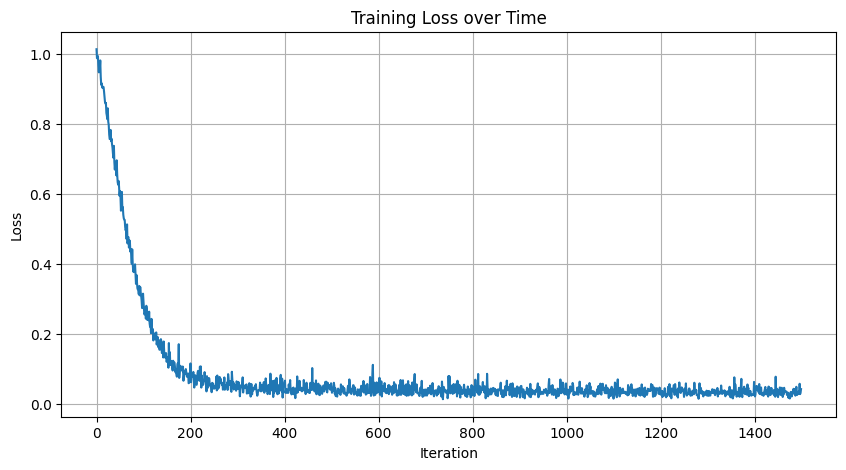

In [14]:
# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss over Time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

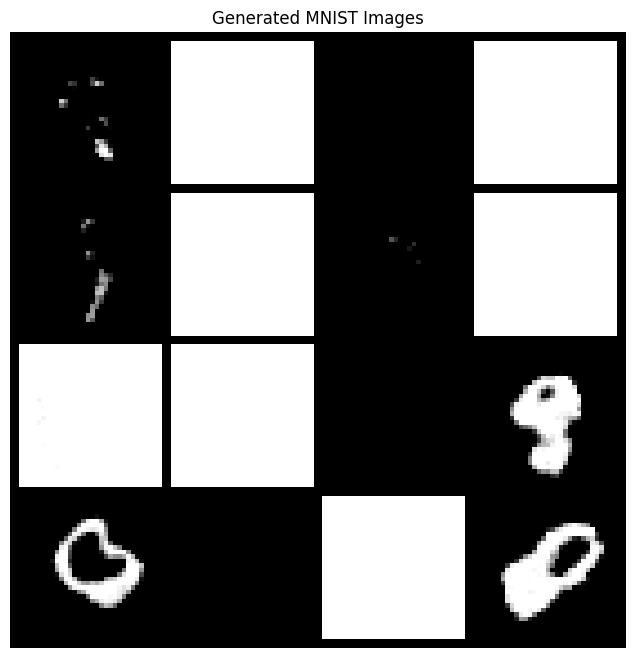

In [16]:
# Generate 16 images using the sampling function
generated_images = sampling(model, batch_size=16)

# For MNIST single-channel images, remove the channel dimension if necessary
generated_images = generated_images.squeeze(1)  # Shape: [16, H, W]

# Create a grid of images
grid = torchvision.utils.make_grid(
    generated_images.unsqueeze(1),  # Add back channel dimension for make_grid
    nrow=4,
    normalize=True,
    value_range=(0, 1)
)

# Plot the images
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.title('Generated MNIST Images')
plt.show()

# Part 5: Questions

1. Where do we scale the values of our training data? What range do we scale the data to? Why do we scale the data in that range?

We scale the values of our training data in the `preprocess_transform` function, which is applied to each image in the dataset during loading. Specifically, the scaling happens in the `Lambda` transform:
```python
preprocess_transform = Compose([
    Resize(image_size),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1),
])
```
We scale the data from the default range of `[0, 1]` (after applying `ToTensor()`) to a new range of `[-1, 1]`. This is achieved by the transformation `t = (t * 2) - 1`.

Neural networks, especially those using activation functions like `SiLU` or `tanh`, often perform better when the input data is centered around zero. This symmetry allows for more balanced gradient updates during training.

2. Why is the cosine scheduler better than the linear scheduler?

The cosine scheduler allocates noise levels in a way that more closely matches the perceptual importance of different timesteps. It places less noise in earlier timesteps and more noise in later timesteps, allowing the model to focus on learning the structure of the data in earlier steps and finer details in later steps.

3. In the forward step, we perform a random number of denoising steps in one forward pass, but in the backward process, we have to perform T forward passes to generate images. Why is that?

Randomly sampling timesteps helps the model learn to predict noise at all stages of the diffusion process, making it robust across different noise levels.

Since each `x_{t-1}` depends on `x_t`, we must perform `T` sequential forward passes through the model to progressively remove noise and reconstruct the image. This iterative process is necessary to approximate the reverse diffusion and gradually transform noise into a coherent image.

4. What is our network learning to predict?

The model aims to approximate the true noise that was added to the original image `x_0` to obtain the noisy image `x_t`. This is achieved by minimizing the mean squared error (MSE) between the true noise ε and the predicted noise `ε_θ(x_t, t)`

5. If we wanted to perform conditional generation; for example, if we wanted to provide our network with a digit and have it produce an image of that digit, what would we have to change?

Adjust the `UNetModel` to accept an additional input representing the condition. Embed the condition (e.g., digit label) into a vector representation using an embedding layer if the condition is categorical.

Modify the timestep embedding to include the condition. This can be done by concatenating the condition embedding with the timestep embedding or combining them through a learnable function.

During sampling, provide the desired condition (e.g., specify the digit you want to generate) to the model at each timestep.